In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
class EmbeddingDotProduct(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(EmbeddingDotProduct, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embeddings(user_indices)
        item_embedding = self.item_embeddings(item_indices)

        if item_indices.dim() == 2:
            user_embedding = user_embedding.unsqueeze(1)

        return (user_embedding * item_embedding).sum(1)

In [96]:
def bpr_loss(positive_scores, negative_scores):
    return -torch.mean(torch.log(torch.sigmoid(positive_scores.unsqueeze(1) - negative_scores)))

In [97]:
scores = np.load("./drive/MyDrive/ВШМ/DL/scores_numpy.npy")
interactions = np.load("./drive/MyDrive/ВШМ/DL/interactions_numpy.npy")

In [98]:
interactions_positive = interactions[scores > 60, :]
np.random.shuffle(interactions_positive)

In [104]:
num_users = int(interactions[:, 0].max()) + 1
num_items = int(interactions[:, 1].max()) + 1
embedding_dim = 64

In [105]:
def generate_negative_samples(num_items, positive_items, num_neg_samples): 
    #there can be intersections with positives but odds are low.
    negative_samples = np.random.choice(num_items, (positive_items.shape[0], num_neg_samples), replace=False)
    return negative_samples

In [106]:
model = EmbeddingDotProduct(num_users, num_items, embedding_dim)

In [107]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmbeddingDotProduct(
  (user_embeddings): Embedding(249012, 64)
  (item_embeddings): Embedding(296111, 64)
)

In [110]:
num_epochs = 5
batch_size = 4000
num_negative_samples = 5

for epoch in range(num_epochs):
    batch_loss = []
    epoch_losses = []

    for ix, batch_start in enumerate(range(0, len(interactions_positive), batch_size)):
        if ix % 5000 == 4999:
          print(f"{ix} batches out of ", len(interactions_positive) // batch_size)
          print(f"loss: {np.mean(batch_loss)}")
          batch_loss = []

        batch_data = interactions_positive[batch_start:batch_start + batch_size]
        batch_positive_users = torch.LongTensor(batch_data[:, 0]).to(device)
        batch_positive_items = torch.LongTensor(batch_data[:, 1]).to(device)
        
        # Sample negative items
        batch_negative_items_np = generate_negative_samples(num_items, batch_data[:, 1], num_negative_samples)
        batch_negative_items = torch.LongTensor(batch_negative_items_np).to(device)
        
        # Calculate scores
        positive_scores = model(batch_positive_users, batch_positive_items)
        negative_scores = model(batch_positive_users, batch_negative_items)
        
        # Compute loss
        loss = bpr_loss(positive_scores, negative_scores)
        batch_loss.append(loss.detach().cpu())
        epoch_losses.append(loss.detach().cpu())
        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {np.mean(epoch_losses)}")
    epoch_losses = []

4999 batches out of  7447
loss: 1.7269418239593506
Epoch 1/5 - Loss: 1.7357902526855469
4999 batches out of  7447
loss: 1.247313141822815
Epoch 2/5 - Loss: 1.2195569276809692
4999 batches out of  7447
loss: 0.7369426488876343
Epoch 3/5 - Loss: 0.7071095108985901
4999 batches out of  7447
loss: 0.38025662302970886
Epoch 4/5 - Loss: 0.36702361702919006
4999 batches out of  7447
loss: 0.19563175737857819
Epoch 5/5 - Loss: 0.1909148246049881


<Axes: >

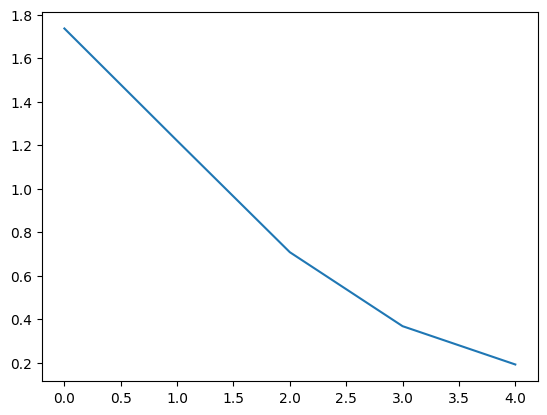

In [113]:
# a bit cringe but i forgot to log losses
loss_per_epoch = [1.7357902526855469, 1.2195569276809692, 0.7071095108985901, 0.36702361702919006, 0.1909148246049881]

pd.Series(loss_per_epoch).plot()